This notebook is the same as the LSTM-multivariate Final Copy. 
The codes are just put in the same cell for easier run. 

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.python import keras
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam
import tensorflow as tf
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

np.random.seed(7)

In [93]:
path = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\geopy\france_cleaned"
#load data
region = "Alsace.csv"
region_name = region.split('.')[0]
df = pd.read_csv(path+'\\'+region)

#feature engineer
def make_cyclic_sin(month):
    a = np.sin((month-1)*(2.*np.pi/12))
    return a
def make_cyclic_cos(month):
    b = np.cos((month-1)*(2.*np.pi/12))
    return b 

# filter the necessary values for temp. prediction 
temp_df = df[df['PARAMETER'] == 'T2M']
temp_df = temp_df.drop('ANN', axis = 1)

# data preprocessing 
temp_df = temp_df.rename(columns = {'YEAR':'year','JAN':1, 'FEB':2,'MAR':3, 'APR':4, 'MAY':5,'JUN':6,
                         'JUL':7, 'AUG':8, 'SEP':9, 'OCT':10, 'NOV':11, 'DEC':12})
temp_df = temp_df.drop(['PARAMETER','LAT','LON'], axis = 1)

temp_df.set_index('year', inplace = True)
df = pd.concat([temp_df.stack()], axis=1)
df.reset_index(inplace = True)

df.rename(columns = {'level_1':'month',0:'avg_temp'}, inplace = True)

# encoding for months 
#cyclic encoding from deep learning notebook
df['month_sin'] = df['month'].apply(lambda row: make_cyclic_sin(row))
df['month_cos'] = df['month'].apply(lambda row: make_cyclic_cos(row))

df['date'] = df[['year','month']].astype(str).apply('-'.join, axis=1)

df.date = pd.to_datetime(df.date)
df = df.set_index('date')

# add the unlablled data (this is for the test set)
unlabelled_dataset = pd.read_excel('to_predict_mult.xlsx')
unlabelled_dataset['date'] = unlabelled_dataset[['year','month']].astype(str).apply('-'.join, axis=1)
unlabelled_dataset.date = pd.to_datetime(unlabelled_dataset.date)
unlabelled_dataset = unlabelled_dataset.set_index('date')

# combine all the data and divide
df = df[['year','avg_temp','month_sin','month_cos']]
unlabelled_dataset = unlabelled_dataset[['year','avg_temp','month_sin','month_cos']]
# fit_transform all the data including the train, valid, and test 
combined_data = pd.concat([df,unlabelled_dataset])

# shifting the avg_temp to t+1 
combined_data['avg_temp'] = combined_data['avg_temp'].shift(1)

# removing the nan value and transform all the data including the train, valid, and test
scaler = MinMaxScaler()
combined_data = combined_data[1:] # shifted to 1
combined_data[['year','avg_temp','month_sin','month_cos']] = scaler.fit_transform(combined_data)

# all the labelled data from 1981 to 2019
data = combined_data[0:467] 

# Train-valid split: 80 percent for the training set and 20 percent for the validation on the labelled data
y = data.avg_temp
X = data
valid_and_test_size = 0.1
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=valid_and_test_size*2, random_state=42, shuffle=False)

#print the shape of the split data. train = (373,4),valid = (94,4)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

# from series convert to array
y_train = y_train.values.reshape(len(y_train),1)
#y_test = y_test.values.reshape(len(y_test),1)
y_valid = y_valid.values.reshape(len(y_valid),1)

(373, 4)
(373,)
(94, 4)
(94,)


In [94]:
look_back=12 # use the last 12 months (01-2019 -> 12-2019)
FORECAST_DISTANCE=1 # forecast on the next month
n_features = len(X_train.columns)


from seglearn.transform import FeatureRep, SegmentXYForecast, last

segmenter = SegmentXYForecast(width=look_back, step=1, y_func=last, forecast=FORECAST_DISTANCE) 
# the segmenter will segment the data according to the parameters set.
X_train_rolled, y_train_rolled,_=segmenter.fit_transform([X_train.values],[y_train.flatten()])
X_valid_rolled, y_valid_rolled,_=segmenter.fit_transform([X_valid.values],[y_valid.flatten()])

In [95]:
BATCH_SIZE = 5
EPOCHS = 30
DROPOUT_RATE= 0.01
LSTM_UNIT_SIZE = 5

# Build the model 
model = Sequential()
model.add(LSTM(LSTM_UNIT_SIZE, activation = 'relu',input_shape = (look_back, n_features)))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(1))


#compile the model
model.compile(optimizer = 'adam', loss = 'mse')

# fit the model

model_path = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France models\\"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)
mc = ModelCheckpoint(model_path+f'{region_name}.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
                    
history = model.fit(X_train_rolled, y_train_rolled, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_valid_rolled,y_valid_rolled), callbacks = [es,mc]) #, callbacks = es

Train on 361 samples, validate on 82 samples
Epoch 1/30
361/361 [==============================] - 1s 2ms/step - loss: 0.1708 - val_loss: 0.0729

Epoch 00001: val_loss improved from inf to 0.07288, saving model to C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France models\\Alsace.h5
Epoch 2/30
361/361 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0297

Epoch 00002: val_loss improved from 0.07288 to 0.02969, saving model to C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France models\\Alsace.h5
Epoch 3/30
361/361 [==============================] - 0s 934us/step - loss: 0.0251 - val_loss: 0.0177

Epoch 00003: val_loss improved from 0.02969 to 0.01775, saving model to C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France models\\Alsace.h5
Epoch 4/30
361/361 [===================

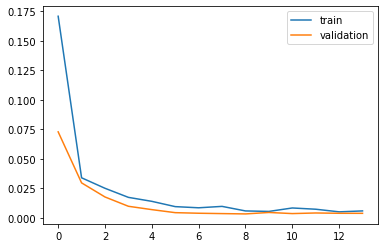

In [96]:
eval_path = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France evaluation\\"

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.savefig(eval_path+f'{region_name} evaluation.png')
plt.show()



In [97]:
# get the saved model 
saved_model = load_model(model_path+f'{region_name}.h5')
print('Model name: ',region_name+'.h5')

Model name:  Alsace.h5


## Predicting the training and getting the inverse

In [33]:
train_y_hat = saved_model.predict(X_train_rolled) 
train_y_hat = pd.DataFrame(train_y_hat)
train_y_hat = train_y_hat.rename(columns = {0:'y_hat'})
for_inverse_scaling = combined_data[12:373]
for_inverse_scaling['y_hat_train'] = train_y_hat['y_hat'].values
for_inverse_scaling_x = for_inverse_scaling[['year','y_hat_train','month_sin','month_cos']]
inverse_scaling_x = scaler.inverse_transform(for_inverse_scaling_x)
train_prediction = pd.DataFrame(inverse_scaling_x).rename(columns = {0:'year',1:'y_hat_train',2:'month_sin',3:'month_cos'})
original_train = for_inverse_scaling[['year','avg_temp','month_sin','month_cos']]
inversed_original_train = scaler.inverse_transform(original_train)
inversed_original_train = pd.DataFrame(inversed_original_train).rename(columns = {0:'year',1:'avg_temp',2:'month_sin',3:'month_cos'})

In [34]:
inversed_original_train.isnull().sum()

year         0
avg_temp     0
month_sin    0
month_cos    0
dtype: int64

In [35]:
# Get the root mean square error for the training set (actual vs. prediction)
print('Train Mean Absolute Error:', mean_absolute_error(inversed_original_train['avg_temp'].values,train_prediction['y_hat_train'].values))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(inversed_original_train['avg_temp'].values,train_prediction['y_hat_train'].values)))

Train Mean Absolute Error: 2.2452215952209484
Train Root Mean Squared Error: 2.821883865425461


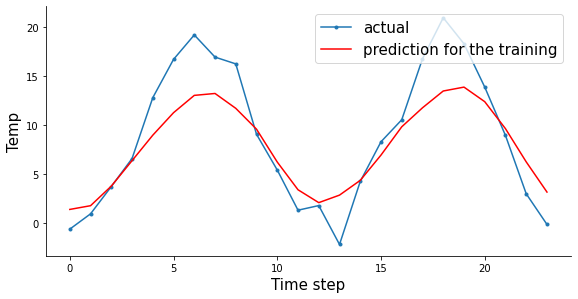

In [36]:
# validation
pred_plot_train = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France prediction plot train\\"

import seaborn as sns

aa=[x for x in range(24)]
plt.figure(figsize=(8,4))
plt.plot(aa, inversed_original_train['avg_temp'].values[:24], marker='.', label="actual") 
plt.plot(aa, train_prediction['y_hat_train'].values[:24], 'r', label="prediction for the training")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Temp', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig(pred_plot_train+f'{region_name} train.png')
plt.show();

### Predicting the validation set and getting the inverse 

In [37]:
valid_y_hat = saved_model.predict(X_valid_rolled)
# convert the prediction to dataframe to be added to the original
#I'm doing this because scaler is fit on a (n,4) shape and predition is only (n,1): has to be the same shape so we need to map it back
valid_y_hat = pd.DataFrame(valid_y_hat)
valid_y_hat = valid_y_hat.rename(columns = {0:'y_hat_valid'})
for_inverse_scaling_valid = combined_data[373+look_back:467] # valid set
for_inverse_scaling_valid['y_hat_valid'] = valid_y_hat['y_hat_valid'].values
for_inverse_scaling_x_valid = for_inverse_scaling_valid[['year','y_hat_valid','month_sin','month_cos']]
inverse_scaling_x_valid = scaler.inverse_transform(for_inverse_scaling_x_valid)
valid_prediction = pd.DataFrame(inverse_scaling_x_valid).rename(columns = {0:'year',1:'y_hat_valid',2:'month_sin',3:'month_cos'})
# get the original valid data
original_valid = for_inverse_scaling_valid[['year','avg_temp','month_sin','month_cos']]
# inverse the original valid set
inversed_original_valid = scaler.inverse_transform(original_valid)
# put the original valid in dataframe 
inversed_original_valid = pd.DataFrame(inversed_original_valid).rename(columns = {0:'year',1:'avg_temp',2:'month_sin',3:'month_cos'})

In [38]:
print('valid Mean Absolute Error:', mean_absolute_error(inversed_original_valid['avg_temp'].values,valid_prediction['y_hat_valid'].values))
print('valid Root Mean Squared Error:',np.sqrt(mean_squared_error(inversed_original_valid['avg_temp'].values,valid_prediction['y_hat_valid'].values)))

valid Mean Absolute Error: 1.8808146406164983
valid Root Mean Squared Error: 2.2327156366715424


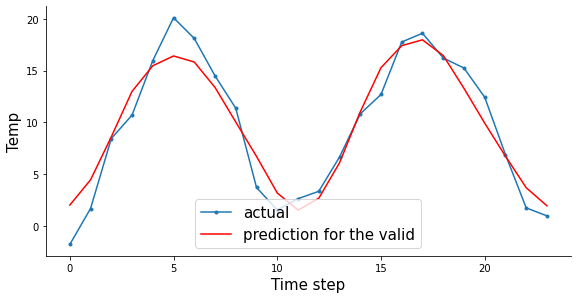

In [39]:
# valid

pred_plot_valid = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France prediction plot valid\\"

import seaborn as sns

aa=[x for x in range(24)]
plt.figure(figsize=(8,4))
plt.plot(aa, inversed_original_valid['avg_temp'].values[:24], marker='.', label="actual") 
plt.plot(aa, valid_prediction['y_hat_valid'].values[:24], 'r', label="prediction for the valid")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Temp', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig(pred_plot_valid+f'{region_name} valid.png')
plt.show();

In [40]:
# plot residuals for training

#inversed_original_train['avg_temp'].values,train_prediction['y_hat_train']
original_y_train =  inversed_original_train['avg_temp'] #y
prediction_train = train_prediction['y_hat_train']
df_residual_train = pd.concat([original_y_train,prediction_train], axis = 1)
df_residual_train['residual'] = df_residual_train['avg_temp'] - df_residual_train['y_hat_train']


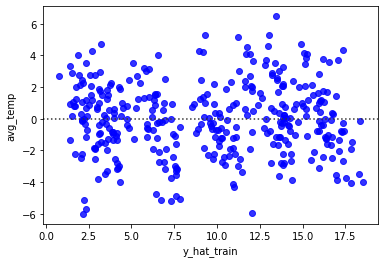

In [41]:
# plot residuals for training
resid_train = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France residual plots train\\"
sns_plot = sns.residplot(x ='y_hat_train', y = 'avg_temp', data = df_residual_train, color = 'blue')
sns_plot.figure.savefig(resid_train+f'{region_name} train residual.png')

In [42]:
# plot residuals for validation 

#inversed_original_valid['avg_temp'].values,valid_prediction['y_hat_valid'].values
original_y_valid = inversed_original_valid['avg_temp']
prediction_valid = valid_prediction['y_hat_valid']
df_residual_valid = pd.concat([original_y_valid,prediction_valid], axis = 1)
df_residual_valid['residual'] = df_residual_valid['avg_temp'] - df_residual_valid['y_hat_valid']


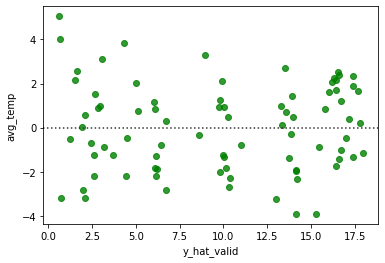

In [43]:
resid_valid = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France residual plots valid\\"

sns_plot_valid = sns.residplot(x ='y_hat_valid', y = 'avg_temp', data = df_residual_valid, color = 'green')
sns_plot_valid.figure.savefig(resid_valid+f'{region_name} valid residual.png')

# Predicting the future dates 

In [87]:
test_set = combined_data[455:] # test set look back of 12 which means use all months in 2018-dec - 2019-12 #454
# this is done because the data was shifted to t+1 before so we need to assume that 2018-dec is the real 2019-jan

In [88]:
#test_set.reset_index(inplace = True)
#test_set[['date','year']] = test_set[['date','year']].shift(-1)

In [89]:
# for loop over to 

pred_list = []
forecast_months = 24 # 2020-2021

prediction = 0

for row in range(forecast_months):
    #print(row)
    look_back = 12
    look_back_set = test_set[row:look_back+row] # [0:12]
    if row != 0:
        look_back_set.iloc[11][1] = prediction
    #print(counter)
    #display(look_back_set)
    x_test_reshaped = look_back_set.values.reshape(1,12,4)
    predict = saved_model.predict(x_test_reshaped)
    prediction = predict[0][0] ## append this to the next test set
    pred_list.append(prediction) 
    

In [91]:
test_set_prediction = pd.DataFrame(pred_list).rename(columns = {0:'prediction'})
test_set[12:]['avg_temp'] =  test_set_prediction['prediction'].values
inverse_test_prediction = test_set[12:][['year','avg_temp','month_sin','month_cos']]
inverse_test_prediction = scaler.inverse_transform(inverse_test_prediction)
final_prediction = pd.DataFrame(inverse_test_prediction).rename(columns = {0:'year',1:'predicted_temp',2:'month_sin',3:'month_cos'})
final_prediction['year'] = final_prediction['year'].shift(-1)
temp_prediction_path = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\Multivariate LSTM\France Predictions\\"
display(final_prediction)
final_prediction.to_excel(temp_prediction_path+f' {region_name}.xlsx')

,year,predicted_temp,month_sin,month_cos
0,2020.0,2.500404,0.000000e+00,1.000000e+00
1,2020.0,0.830312,5.000000e-01,8.660254e-01
2,2020.0,1.519897,8.660254e-01,5.000000e-01
3,2020.0,4.612776,1.000000e+00,0.000000e+00
4,2020.0,9.308450,8.660254e-01,-5.000000e-01
5,2020.0,13.570695,5.000000e-01,-8.660254e-01
6,2020.0,16.207430,2.220446e-16,-1.000000e+00
7,2020.0,16.651884,-5.000000e-01,-8.660254e-01
8,2020.0,14.952827,-8.660254e-01,-5.000000e-01
9,2020.0,11.772986,-1.000000e+00,-2.220446e-16


In [ ]:
# 

In [26]:
# plotting 
df_prediction = final_prediction.rename(columns = {'predicted_temp':'avg_temp'}) # 24
inv_trans_com = pd.DataFrame(scaler.inverse_transform(combined_data)).rename(columns = {0:'year',1:'avg_temp',2:'month_sin',3:'month_cos'})
plot_all_temp = pd.concat([inv_trans_com[:-24],df_prediction])
plot_all_temp.tail(49)

,year,avg_temp,month_sin,month_cos
442,2017.0,4.000000,-5.000000e-01,8.660254e-01
443,2018.0,0.860000,0.000000e+00,1.000000e+00
444,2018.0,4.400000,5.000000e-01,8.660254e-01
445,2018.0,-2.010000,8.660254e-01,5.000000e-01
446,2018.0,3.490000,1.000000e+00,0.000000e+00
447,2018.0,12.500000,8.660254e-01,-5.000000e-01
448,2018.0,15.530000,5.000000e-01,-8.660254e-01
449,2018.0,18.160000,2.220446e-16,-1.000000e+00
450,2018.0,21.070000,-5.000000e-01,-8.660254e-01
451,2018.0,20.630000,-8.660254e-01,-5.000000e-01


In [22]:
plot_df = combined_data.copy() # combined data here is already shifted so it starts with 1981-02-01
plot_df.shape
plot_df['with_pred_temp'] = plot_all_temp['avg_temp'].values

In [23]:
plot_df

,year,avg_temp,month_sin,month_cos,with_pred_temp
date,,,,,
1981-02-01,0.000,0.126350,0.750000,0.933013,-2.680000
1981-03-01,0.000,0.173813,0.933013,0.750000,-1.230000
1981-04-01,0.000,0.434697,1.000000,0.500000,6.740000
1981-05-01,0.000,0.508347,0.933013,0.250000,8.990000
1981-06-01,0.000,0.621931,0.750000,0.066987,12.460000
1981-07-01,0.000,0.720458,0.500000,0.000000,15.470000
1981-08-01,0.000,0.762357,0.250000,0.066987,16.750000
1981-09-01,0.000,0.781015,0.066987,0.250000,17.320000
1981-10-01,0.000,0.693290,0.000000,0.500000,14.640000
